In [2]:
import os
import pandas as pd 
import gensim.downloader as api

In this how-to tutorial, we demonstrate how Gensim libraries can be used in a 2-step supervised learning problem. 

* Step 0: Preprocessing.
* Step 1: Text-embedding.
* Step 2: Classification.

We will show how Gensim's `sklearn_api` can be used in a larger classification comparison pipeline, based on `sci-kit` learn principles. As such, we will utilize the external library `sklearn` to perform some of the comparisons.

We will compare the output of models using Gensim techniques with the output of models using other techniques.

# Load and read data

In [3]:
api.load('20-newsgroups')
news_df = pd.read_json(os.path.join("~", "gensim-data", "20-newsgroups",  "20-newsgroups.gz"), lines=True)
news_df.head(2)

,data,id,set,topic
0,From: db7n+@andrew.cmu.edu (D. Andrew Byler)\n...,21408,train,soc.religion.christian
1,From: mpaul@unl.edu (marxhausen paul)\nSubject...,21388,train,soc.religion.christian


In [4]:
print(news_df['data'][0][:1000])

From: db7n+@andrew.cmu.edu (D. Andrew Byler)
Subject: Re: Serbian genocide Work of God?
Organization: Freshman, Civil Engineering, Carnegie Mellon, Pittsburgh, PA
Lines: 61

Vera Shanti Noyes writes;

>this is what indicates to me that you may believe in predestination.
>am i correct?  i do not believe in predestination -- i believe we all
>choose whether or not we will accept God's gift of salvation to us.
>again, fundamental difference which can't really be resolved.

Of course I believe in Predestination.  It's a very biblical doctrine as
Romans 8.28-30 shows (among other passages).  Furthermore, the Church
has always taught predestination, from the very beginning.  But to say
that I believe in Predestination does not mean I do not believe in free
will.  Men freely choose the course of their life, which is also
affected by the grace of God.  However, unlike the Calvinists and
Jansenists, I hold that grace is resistable, otherwise you end up with
the idiocy of denying the universal s

In [5]:
news_df['topic'].value_counts()

rec.sport.hockey            999
soc.religion.christian      997
rec.motorcycles             996
rec.sport.baseball          994
sci.crypt                   991
rec.autos                   990
sci.med                     990
comp.windows.x              988
sci.space                   987
comp.os.ms-windows.misc     985
sci.electronics             984
comp.sys.ibm.pc.hardware    982
misc.forsale                975
comp.graphics               973
comp.sys.mac.hardware       963
talk.politics.mideast       940
talk.politics.guns          910
alt.atheism                 799
talk.politics.misc          775
talk.religion.misc          628
Name: topic, dtype: int64

# Let's start by defining our prediction task

For the sake of simplicity, let's recast this multiclass dataset into a binary prediction problem by defining the following 2 classes:

* `class 0 = {comp.*, sci.*}` articles
* `class 1 = {talk.*, rec.*}` articles

and building classifiers of the form $p(y | x)$ where $x$ is raw input text, and $y$ is one of the two class labels.

In [90]:
news_df = (news_df
           .loc[lambda df: df['topic'].str.contains('comp.|sci.|talk.|rec.')]
           .assign(label=lambda df: df['topic'].apply(lambda x: 1 if ('comp' in x) or ('sci' in x) else 0 ))
          )

X_df = news_df['data'].reset_index(drop=True)
y_df = news_df['label'].reset_index(drop=True)

In [91]:
y_df.value_counts()

1    8843
0    7232
Name: label, dtype: int64

## Pipelining

Machine learning used to take the form of extensive data-analysis and feature-extraction. For example, we might start by analyzing the words being used in each `class`, and take counts of specific words, say "machine", or "Iraq". However, the beauty of the techniques offered in many modern machine-learning libraries, like Gensim, is that we can learn the relevant features based on our prediction task.

Doing an apples-to-apples comparison across model-choices, then, is of great importance. Especially with text-based processing, which often entails many steps, it's of great importance to be organized with training vs. test data. We will utilize `sklearn` Pipelines to properly separate our data. __A key error that is easy to make:__ performing an intermediate step on a full-dataset and then doing a test-train split for just the classification step. This results in signal leakage and overfitting.

In [25]:
## classifiers
from sklearn.linear_model import LogisticRegressionCV

## text transformers
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

## pipeline and gridsearch
from sklearn.pipeline import Pipeline

## tests
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold

from gensim.sklearn_api import D2VTransformer

In [101]:
pipeline__cv_lr = Pipeline([
        ('cv', CountVectorizer(min_df=.05, max_df=.4)),
        ('lr', LogisticRegressionCV(Cs=10, cv=10, max_iter=1000)),
])

pipeline__tfidf_lr = Pipeline([
        ('tfidf', TfidfVectorizer(min_df=.05, max_df=.4)),
        ('lr', LogisticRegressionCV(Cs=10, cv=10, max_iter=1000))
])

We would like to some pipelines using Gensim's `sklearn_api` package into the mix.

But first, we have to develop some preprocessing steps. Gensim expects slightly different inputs for its classes than SKLearn. Here is a way to seamlessly integrate Gensim magic into your testing pipeline.

In [58]:
from gensim.sklearn_api import LdaTransformer
from gensim.corpora import Dictionary
from sklearn.base import BaseEstimator, MetaEstimatorMixin
import re

In [138]:
class MyTokenizer(BaseEstimator, MetaEstimatorMixin):
    """Tokenize input strings based on a simple word-boundary pattern."""
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        ## split on word-boundary. A simple technique, yes, but mirrors what sklearn does to preprocess:
        ## https://github.com/scikit-learn/scikit-learn/blob/7b136e9/sklearn/feature_extraction/text.py#L261-L266
        token_pattern = re.compile(r"(?u)\b\w\w+\b")
        parser = lambda doc: token_pattern.findall(doc)
        return X.apply(parser).values


class Doc2BOW(BaseEstimator, MetaEstimatorMixin):
    """Transform a corpus into Bag-of-Word representation."""
    def fit(self, X, y=None):
        self.dictionary = Dictionary(X)
        return self
        
    def transform(self, X):
        output = []
        for x in X:
            output.append(self.dictionary.doc2bow(x))
        return output

While we are at it, we'll show how to extend another popular Gensim class, Word2Vec, to use this along with our other document-based pipelines. A common approach when using word-based embeddings is to represent the document as an average of such embeddings. We can easily extend Gensim's Word2Vec package to do just this:

In [115]:
from gensim.sklearn_api import W2VTransformer
import numpy as np

class W2VTransformerDocLevel(W2VTransformer):
    """Extend Gensim's Word2Vec sklearn-wrapper class to further transform word-vectors into doc-vectors by
    averaging the words in each document."""
    
    def __init__(self, size=100, alpha=0.025, window=5, min_count=5, max_vocab_size=None, sample=1e-3, seed=1,
                 workers=3, min_alpha=0.0001, sg=0, hs=0, negative=5, cbow_mean=1, hashfxn=hash, iter=5, null_word=0,
                 trim_rule=None, sorted_vocab=1, batch_words=10000):
        super().__init__(size, alpha, window, min_count, max_vocab_size, sample, seed, workers, min_alpha, sg, hs, negative, cbow_mean, hashfxn, iter, null_word, trim_rule, sorted_vocab, batch_words)
    
    def transform(self, docs):      
        doc_vecs = []
        for doc in docs:
            ## for each document generate a word matrix
            word_vectors_per_doc = []
            for word in doc:
                ## handle out-of vocabulary words
                if word in self.gensim_model.wv:
                    word_vectors_per_doc.append(self.gensim_model.wv[word])
                    
            word_vectors_per_doc = np.array(word_vectors_per_doc)
            ## take the column-wise mean of this matrix and store
            doc_vecs.append(word_vectors_per_doc.mean(axis=0))
        return np.array(doc_vecs)

In [143]:
pipeline__lda = Pipeline([
    ('tokenize', MyTokenizer()),
    ('doc2bow', Doc2BOW()),
    ('lda', LdaTransformer(num_topics=200, iterations=50)),
    ('lr', LogisticRegressionCV(Cs=10, cv=10, max_iter=5000)) ## we were seeing failure to converge at a lower number...
])

pipeline__d2v = Pipeline([
    ('tokenize', MyTokenizer()),
    ('d2v', D2VTransformer(size=200, iter=50)),
    ('lr', LogisticRegressionCV(Cs=10, cv=10, max_iter=1000))
])

pipeline__w2v = Pipeline([
    ('tokenize', MyTokenizer()),
    ('w2v', W2VTransformerDocLevel(size=200, iter=50)),
    ('lr', LogisticRegressionCV(Cs=10, cv=10, max_iter=1000))
])

In [144]:
pipelines = {
    'cv_lr': pipeline__cv_lr,
    'tfidf_lr': pipeline__tfidf_lr,
    'lda_lr': pipeline__lda,
    'w2v_lr': pipeline__w2v,
    'd2v_lr': pipeline__d2v
}

In [145]:
from collections import defaultdict

In [116]:
scores = defaultdict(dict)

kf = KFold(n_splits=3)
for k_fold, chunk in enumerate(kf.split(X_df)):
    train_index, test_index = chunk
    print("kfold", k_fold, "TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X_df.loc[train_index], X_df.loc[test_index]
    y_train, y_test = y_df.loc[train_index], y_df.loc[test_index]
    
    for pipe_name, pipe in pipelines.items():
        print("fitting %s..." % pipe_name)
        
        pipe.fit(X_train, y_train)
        y_pred = pipe.predict_proba(X_test)
        scores[pipe_name][k_fold] = roc_auc_score(y_test, y_pred[:, 1])

kfold 0 TRAIN: [ 5359  5360  5361 ... 16072 16073 16074] TEST: [   0    1    2 ... 5356 5357 5358]
fitting cv_lr...
fitting tfidf_lr...
fitting lda_lr...


/usr/local/lib/python3.6/dist-packages/gensim/models/ldamodel.py:1030: RuntimeWarning: divide by zero encountered in log
  diff = np.log(self.expElogbeta)


fitting w2v_lr...
fitting d2v_lr...
kfold 1 TRAIN: [    0     1     2 ... 16072 16073 16074] TEST: [ 5359  5360  5361 ... 10714 10715 10716]
fitting cv_lr...
fitting tfidf_lr...
fitting lda_lr...


/usr/local/lib/python3.6/dist-packages/gensim/models/ldamodel.py:1030: RuntimeWarning: divide by zero encountered in log
  diff = np.log(self.expElogbeta)


fitting w2v_lr...
fitting d2v_lr...
kfold 2 TRAIN: [    0     1     2 ... 10714 10715 10716] TEST: [10717 10718 10719 ... 16072 16073 16074]
fitting cv_lr...
fitting tfidf_lr...
fitting lda_lr...


/usr/local/lib/python3.6/dist-packages/gensim/models/ldamodel.py:1030: RuntimeWarning: divide by zero encountered in log
  diff = np.log(self.expElogbeta)


fitting w2v_lr...
fitting d2v_lr...


In [134]:
import seaborn as sns
import matplotlib.pyplot as plt

In [123]:
scores_df = pd.DataFrame(scores)
scores_df

,cv_lr,tfidf_lr,lda_lr,w2v_lr,d2v_lr
0,0.868716,0.876873,0.522912,0.968123,0.954690
1,0.885730,0.893861,0.500000,0.962023,0.952511
2,0.917401,0.920375,0.500000,0.974478,0.963138


Text(0.5, 0, 'Pipelines')

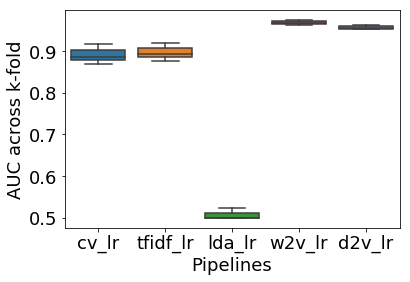

In [136]:
plt.rc("font", size=18)
sns.boxplot(
    x='level_0',
    y=0,
    data=scores_df.unstack().reset_index()
)
plt.ylabel("AUC across k-fold")
plt.xlabel("Pipelines")

## TODO: 
* Dictionary2Bow -- can't that be fit into the LDA Transformer?
* LDA, D2V, W2v check for `doc[0]`..... this fails when using non zero-indexed inputs like dataframes.
* W2VTransformer doesn't have any handling for train/test splits and fails on out-of-vocabulary errors.

## Extra: Additional preprocessing steps

The dirty magic of text-data processing success often lies in how well you preprocess your data. While there are many things that can be done, they are often task-dependent. Here, we give some methods for several light preprocessing:

* __Lemmatize__: take the root form of a word (eg. "running"=>"run")
* __Remove stopwords__: commonly-used words that carry little meaning (eg. "and", "the")
* __Identify part-of-speech tags__: determine if a word is a "Verb" or a "Noun". This can help for commonly used words like "well", that have different meanings based on whether they appear as a noun or, say, and adjective.
* __Identify noun-phrases__: determine noun-chunks and join these together. This can help for compound phrases that carry meaning together but are meaningless seperately (ex. "climate change" carries different meaning than "climate" or "change" separately).

but note that there's a lot more that can be done. Care should be taken to explore this part of your classification task: often, the "black magic" of a good classifier vs. an underperforming one lies in how well you preprocess.

\** Note that often one can preprocessed data outside of a pipeline. A good rule-of-thumb in determining whether to chain operations or not is whether that step learns internal parameters. No matter what they are, say, a threshold like in CountVectorizer, or an embedding matrix as in Doc2Vec, it's a good idea to train on training data separately. Since our preprocessing is stateless -- i.e., we did not learn a model -- and time-consuming, we can safely process the entire set beforehand. 

In [8]:
import spacy
import time
from spacy.parts_of_speech import *
from nltk.corpus import stopwords
from concurrent.futures import ProcessPoolExecutor

stopwords = set(stopwords.words('english'))
nlp = spacy.load("en_core_web_sm")

## X 
def preprocess_text_line(text):
    """Simple preprocessing to:
        * lemmatize
        * remove stopwords and punctuation
        * concatenate POS to word for disambiguation.
    """
    output = []
    
    doc = nlp(text)
    for word in doc:
        if (word.pos not in (PUNCT, SPACE)) and (word.lemma_ not in stopwords):
            processed = word.lemma_ + "-" + word.pos_
            output.append(processed)
        
    return ' '.join(output)

def preprocess_noun_phrase_line(text):
    """Nounphrase preprocessing that:
        * extracts noun phrases
        * lemmatizes
        * removes stopwords and punctuation
    """
    output = []
      
    doc = nlp(text)
    for noun_phrase in doc.noun_chunks:
        noun_phrase_output = []
        for word in noun_phrase:
            if (word.pos not in (PUNCT, SPACE, NUM)) and (word.lemma_ not in stopwords):
                noun_phrase_output.append(word.lemma_)
        noun_phrase_output = '-'.join(noun_phrase_output)
        output.append(noun_phrase_output)
        
    return ' '.join(output)


def time_process_X(input_X, processing_func):
    """Run process_text_line over a DF and time the output. Return series of processed data."""
    processed_X = []
    now = time.time()

    with ProcessPoolExecutor() as executor:
        for idx, x, in enumerate(executor.map(processing_func, input_X)): ##
            if idx % 2000 == 0:
                print("finished %d in %f..." % (idx, time.time()- now))
                now= time.time()

            processed_X.append(x) ##
        
    return pd.Series(processed_X)

In [9]:
X_df = time_process_X(X_df, preprocess_text_line)

finished 0 in 2.782411...
finished 2000 in 88.621636...
finished 4000 in 169.495885...
finished 6000 in 134.525473...
finished 8000 in 146.415887...
finished 10000 in 140.682751...
finished 12000 in 87.144323...
finished 14000 in 100.570627...
finished 16000 in 112.727224...


In [22]:
X_df[10]

'ds@aris.nswc.navy.mil-PROPN demetrios-PROPN sapounas-PROPN subject-NOUN 3d-ADJ display-NOUN software-NOUN organization-PROPN nswc-PROPN lines-PROPN 19-NUM -PRON--PRON need-NOUN display-VERB 2-NUM 1/2-NUM surface-NOUN x-NOUN use-VERB xlib-PROPN xt-PROPN xm-PROPN anyone-NOUN know-VERB package-NOUN available-ADJ internet-NOUN able-ADJ work-NOUN -PRON--PRON look-VERB stand-VERB alone-ADJ package-NOUN provide-VERB similar-ADJ function-NOUN xprism3-PROPN available-ADJ khoros-PROPN without-ADP numerous-ADJ library-NOUN require-VERB -PRON--PRON -PRON--PRON want-VERB able-ADJ recompile-VERB -PRON--PRON run-VERB -PRON--PRON various-ADJ platform-NOUN sgi-NOUN i486s-PROPN unix-PROPN help-NOUN appreciate-VERB =-X =-SYM demetrios-PROPN sapounas-PROPN tel-PROPN +-SYM 1-NUM 703-NUM 663.8332-NUM l-PROPN 115-NUM nswc-PROPN fax-NOUN +-SYM 1-NUM 703-NUM 663.1939-NUM dahlgren-PROPN va-PROPN 22448-NUM --SYM 5000-NUM usa-PROPN email-NOUN ds@aris.nswc.navy.mil-PROPN =-SYM =-SYM =-SYM'